In [1550]:
import os
from dotenv import load_dotenv
load_dotenv()
HF_API_KEY = os.getenv("HF_TOKEN") 
os.environ["LANGSMITH_TRACING"]= "True"
LANGSMITH_API_KEY=os.getenv("LANGCHAIN_API_KEY")
LANGSMITH_PROJECT ="Tracing Project"
OPENAI_API_KEY=os.getenv("OPENAI_API_KEY")
GROQ_API_KEY =os.getenv("GROQ_API_KEY") 

TAVILY_KEY= os.getenv("TAVILY_API_KEY")  
API_KEY=os.getenv("API_KEY_WEATHER")  

In [1551]:

#from langchain_google_genai import ChatGoogleGenerativeAI
#model=ChatGoogleGenerativeAI(model='gemini-1.5-flash')

 
from langchain_openai import ChatOpenAI
model= ChatOpenAI(model='gpt-4o-mini')

In [1552]:
from pydantic import BaseModel 
from typing import Any, Optional, List, Dict,Union
from typing import Annotated
class AgentState(BaseModel):
    messages: Annotated[List[str], "accumulate"]
    fetch_info: Optional[Dict] = None
    hotel_info: Optional[List[Dict[str, Any]]] = None
    weather_info: Optional[Dict] = None
    attraction_info: Optional[str] = None
    rate_info: Optional[str] = None
    itinerary_info: Optional[str] = None
    summary_info: Optional[str] = None
    error: Optional[str] = None

## retrive weather

In [1553]:
def search_weather_info(travelInformation:AgentState)->AgentState:
    import requests
    city_to = travelInformation["data"]["cityto"]
    travel_date = travelInformation["data"]["traveldate"]

    print(city_to)          
    print(travel_date)  # format: YYYY-MM-DD

    # 1. Get Current Weather
    current_url = f"http://api.weatherapi.com/v1/current.json?key={API_KEY}&q={city_to}"
    current_response = requests.get(current_url)
    current_data = current_response.json()

    # 2. Get Forecast Weather for Travel Date
    forecast_url = f"http://api.weatherapi.com/v1/forecast.json?key={API_KEY}&q={city_to}&dt={travel_date}"
    forecast_response = requests.get(forecast_url)
    forecast_data = forecast_response.json()
    print(forecast_data)
        # Safe access to forecast info
    forecast_day = forecast_data.get("forecast", {}).get("forecastday", [])
    if forecast_day:
            weather_info["travel_date_weather"] = {
                "date": travel_date,
                "avgtemp_c": forecast_day[0]["day"]["avgtemp_c"],
                "condition": forecast_day[0]["day"]["condition"]["text"]
            }
    else:
        print(f"[Notice] No forecast available for date: {travel_date}")
    # 📦 Output Both
    weather_info = {
        "city": city_to,
        "current_weather": {
            "temp_c": current_data['current']['temp_c'],
            "condition": current_data['current']['condition']['text']
        },
        "travel_date_weather": {
            "date": travel_date,
            "avgtemp_c": forecast_data['forecast']['forecastday'][0]['day']['avgtemp_c'],
            "condition": forecast_data['forecast']['forecastday'][0]['day']['condition']['text']
        }
    }
    
    #print(weather_info)
    return weather_info


In [1554]:
import requests
from datetime import datetime
def get_weather_info1(state: AgentState) -> AgentState: 
    print(state)
    print(state.fetch_info['cityto'])
    city_to = state.fetch_info["cityto"]
    travel_date = state.fetch_info["traveldate"]
    weather_info = {
        "city": city_to,
        "current_weather": None,
        "travel_date_weather": None
    }

    try:
        # Current weather API call
        current_url = f"http://api.weatherapi.com/v1/current.json?key={API_KEY}&q={city_to}"
        current_data = requests.get(current_url).json()
        
        weather_info["current_weather"] = {
            "temp_c": current_data["current"]["temp_c"],
            "condition": current_data["current"]["condition"]["text"]
        }
    except Exception as e:
        print(f"[Warning] Failed to get current weather: {e}")

    try:
        # Forecast weather for travel date
        forecast_url = f"http://api.weatherapi.com/v1/forecast.json?key={API_KEY}&q={city_to}&dt={travel_date}"
        forecast_data = requests.get(forecast_url).json()

        # Safe access to forecast info
        forecast_day = forecast_data.get("forecast", {}).get("forecastday", [])
        if forecast_day:
            weather_info = {
                "date": travel_date,
                "avgtemp_c": forecast_day[0]["day"]["avgtemp_c"],
                "condition": forecast_day[0]["day"]["condition"]["text"]
            }
            print(f"weather info : {weather_info}")
            return state.model_copy(update={"weather_info": weather_info})
        else:
            travel_date = datetime.now();
            # Forecast weather for travel date
            forecast_url = f"http://api.weatherapi.com/v1/forecast.json?key={API_KEY}&q={city_to}&dt={travel_date}"
            forecast_data = requests.get(forecast_url).json()

            # Safe access to forecast info
            forecast_day = forecast_data.get("forecast", {}).get("forecastday", [])
            if forecast_day:
                weather_info = {
                "date": travel_date,
                "avgtemp_c": forecast_day[0]["day"]["avgtemp_c"],
                "condition": forecast_day[0]["day"]["condition"]["text"]
                }
                print(f"weather info : {weather_info}")
                return state.model_copy(update={"weather_info": weather_info})
            else:
                return state.model_copy(update={"error": f"[Notice] No forecast available for date: {travel_date}"})

    except Exception as e:
        print(f"[Warning] Failed to get travel date forecast: {e}")
        return state.model_copy(update={"error": f"Failed to get travel date forecast: {e}"})
   

    

## Get hotel information

In [1555]:
from tavily import TavilyClient
from openai import OpenAI
import json
import ast
# Set your API keys 

# Initialize clients
tavily = TavilyClient(api_key=TAVILY_KEY)
client = OpenAI(api_key=OPENAI_API_KEY)
def get_hotel_data(state:AgentState) -> AgentState:
   # state.fetch_info['data']
    # Step 1: Get hotel search results from Tavily 
    print(state)
   # print(state.fetch_info['data']['cityto'])
    city =state.fetch_info['cityto']
    query = f"Top 10 hotels in {city} with average price per night"
    response = tavily.search(query, search_depth="basic", include_answer=True)

    # Extract raw text content from Tavily's answer and snippets
    search_text = response.get("answer", "") + "\n"
    for result in response.get("results", []):
        search_text += result.get("content", "") + "\n"

    # Step 2: Ask OpenAI to extract hotel data into JSON
    system_prompt = "Extract hotel names and average prices from the text into JSON format. Only include hotels with clear price info in Native currency. Output an array of objects with 'hotel_name' and 'average_price'."

    user_prompt = f"Text:\n{search_text.strip()}"

    completion = client.chat.completions.create(
        model="o4-mini",
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt}
        ], 
    ) 
    json_output = completion.choices[0].message.content
    print(f"get_hotel_data retun0-> {json.loads(json_output)}")
    try:
       parsed_data= json.loads(json_output)
       # return json.loads(json_output)
       #return state.model_copy(update={"hotel_info": json.loads(json_output)})
       hotel_info_list = ast.literal_eval(json_output)
       print(f"get_hotel_data retun1-> {hotel_info_list}")
       # Take first dict from list
       if len(hotel_info_list)>0:
            hotel_info=hotel_info_list
            print(hotel_info)
            return state.model_copy(update={"hotel_info": hotel_info_list})
       else :
           return state.model_copy(update={"error": "No listt of hotel in your place"})
    except json.JSONDecodeError:
        return state.model_copy(update={"error": "OpenAI returned invalid JSON"})

## Calculate expenses

In [1556]:
from langchain_core.prompts import ChatPromptTemplate

def calculate_expense_llm(state:AgentState) -> AgentState:
    country= state.fetch_info['cityto']
    days =state.fetch_info['days']
    daily_expense = 11
    exchange_rate = state.currency_info["exchange"]
    expense_prompt = ChatPromptTemplate.from_template("""
    You are a travel expense calculator.

    Given:
    - Country: {country}
    - Days of travel: {days}
    - Average daily expense in local currency: {daily_expense}
    - Exchange rate (1 local currency to USD): {exchange_rate}

    Calculate:
    1. Total cost in local currency
    2. Total cost in USD

    Format:
    Total (Local): ¥xxxx
    Total (USD): $xxx.xx
    """)
    prompt = expense_prompt.format_messages(
            country=country,
            days=days,
            daily_expense=daily_expense,
            exchange_rate=exchange_rate
        )
    response = model.invoke(prompt)
    return response.content

## get Attraction inforamtion based on city and travel date if weather for travel date not available get current date

In [1557]:
from langchain.schema import HumanMessage
def get_attraction(state:AgentState)->AgentState:
       
       city = state.fetch_info['cityto']
       days = state.fetch_info['days']
       prompt = f"""
You are a travel planner. Suggest popular tourist attractions in {city} for a {days}-day trip.

Rules:
- Prioritize top-rated attractions
- Group attractions by day (Day 1, Day 2, etc.)
- Include a mix of cultural, historic, shopping, and natural places
- Be concise but informative

Format:
Day 1:
- Attraction 1: short description
- Attraction 2: short description

Day 2:
...

Only include real and well-known attractions. Don't repeat places.
"""
       response = model.invoke([HumanMessage(content=prompt)])
       return state.model_copy(update={"attraction_info": str(response.content)})
   

## get exchange rate

In [1558]:

def get_exchange_rate_with_tavily(state: AgentState) -> AgentState:
    base= state.fetch_info['cityfrom']
    target= state.fetch_info['cityto']
    query = f"{base} to {target} exchange rate today"
    url = "https://api.tavily.com/search"

    payload = {
        "query": query,
        "search_depth": "basic",
        "include_answer": True
    }

    headers = {
        "Authorization": f"Bearer {TAVILY_KEY}",
        "Content-Type": "application/json"
    }

    response = requests.post(url, json=payload, headers=headers)
    result = response.json()

    # Extract from answer or snippet
    answer = result.get("answer", "")
    print(answer)
    if answer: 
        return state.model_copy(update= {"rate_info": str(answer)})
    else:
        # Fallback to first snippet
        snippet = result.get("results", [{}])[0].get("content", "")
        return state.model_copy(update= {"error": "No value at the moment"})

# gendrate itienery

In [1559]:
from langchain.chat_models import ChatOpenAI
from langchain.schema import HumanMessage, SystemMessage

def get_itinery_generation(state:AgentState)->AgentState:
    messages = state.messages[0]
    fetch_info = state.fetch_info
    hotel_info = state.hotel_info
    weather_info = state.weather_info
    attraction_info=  state.attraction_info
    rate_info = state.rate_info
    """
    Generate a day-by-day travel itinerary in plain text using LangChain's OpenAI Chat model.

    Args:
        messages (list of str): Conversation context messages (e.g., user queries).
        fetch_info (dict): Trip details with keys 'cityfrom', 'cityto', 'days', 'traveldate'.
        hotel_info (list of dict): Available hotel options (each dict contains 'type' and 'price').
        weather_info (dict): Weather details with 'avgtemp_c' and 'condition'.
        attraction_info (str): Markdown-formatted string with attractions for each day.
        rate_info (str or number): Currency exchange rate information.

    Returns:
        str: A plain-text itinerary, organized by day, generated by the OpenAI LLM.
    """
    # Initialize the LLM (temperature=0 for deterministic output)
    llm = ChatOpenAI(temperature=0)
    system_message = SystemMessage(content="You are an experienced travel planning assistant.")
    
    # Include prior conversation messages for context
    messages_chain = [system_message]
    if messages:
        for msg in messages:
            messages_chain.append(HumanMessage(content=msg))
    
    # Format trip details into prompt
    trip_details = (
        f"Trip details:\n"
        f"- From: {fetch_info.get('cityfrom')}\n"
        f"- To: {fetch_info.get('cityto')}\n"
        f"- Travel dates: {fetch_info.get('traveldate')}\n"
        f"- Duration: {fetch_info.get('days')} days"
    )
    weather_details = (
        f"Weather forecast:\n"
        f"- Average temperature: {weather_info.get('avgtemp_c')}°C\n"
        f"- Conditions: {weather_info.get('condition')}"
    )

    # Format hotel options
    hotels_formatted = []
    for hotel in hotel_info:
        hotel_desc = []
        if 'type' in hotel:
            hotel_desc.append(hotel['type'])
        if 'price' in hotel:
            hotel_desc.append(f"Price: {hotel['price']}")
        if hotel_desc:
            hotels_formatted.append("- " + " | ".join(hotel_desc))
    hotels_details = "Hotel options:\n" + "\n".join(hotels_formatted) if hotels_formatted else "Hotel options: N/A"

    # Include attractions and currency info
    attractions_details = f"Attractions by day (markdown):\n{attraction_info}"
    currency_details = f"Currency exchange rate: {rate_info}"

    # Combine everything into a user prompt
    prompt = (
        f"{trip_details}\n\n"
        f"{weather_details}\n\n"
        f"{hotels_details}\n\n"
        f"{attractions_details}\n\n"
        f"{currency_details}\n\n"
        "Using the above information, write a plain-text, day-by-day itinerary for this trip. "
        "Label each day (Day 1, Day 2, etc.) and include activities based on the attractions. "
        "Keep each day's description concise (3-5 sentences)."
    )

    messages_chain.append(HumanMessage(content=prompt))
    # Generate itinerary text
    response = llm(messages_chain)
    print(response.content)
    return state.model_copy(update={"itinerary_info": response.content}) 

## grndrate trip summary based on all avilable information

In [1560]:
def generate_trip_summary(state:AgentState)->AgentState:
    messages = state.messages[0]
    fetch_info = state.fetch_info
    hotel_info = state.hotel_info
    weather_info = state.weather_info
    attraction_info=  state.attraction_info
    rate_info = state.rate_info
    print("Generate trip summary")
    """
    Generate a brief trip summary paragraph in plain text using LangChain's OpenAI Chat model.

    The summary includes weather conditions, hotel price range, major attractions,
    currency rate, and estimated average cost per day.

    Args:
        messages (list of str): Conversation context messages (optional).
        fetch_info (dict): Trip details (e.g., cities, dates; optional for summary).
        hotel_info (list of dict): Available hotel options with 'type' and 'price'.
        weather_info (dict): Weather details with 'avgtemp_c' and 'condition'.
        attraction_info (str): Markdown-formatted string with attractions (for highlights).
        rate_info (str or number): Currency exchange rate information.

    Returns:
        str: A plain-text paragraph summarizing the trip, generated by the OpenAI LLM.
    """
    llm = ChatOpenAI(temperature=0)
    system_message = SystemMessage(content="You are an experienced travel planning assistant.")
    
    messages_chain = [system_message]
    if messages:
        for msg in messages:
            messages_chain.append(HumanMessage(content=msg))

    # Compute price range and average from hotel_info
    prices = [hotel.get('price') for hotel in hotel_info if hotel.get('price') is not None]
    if prices:
        min_price = min(prices)
        max_price = max(prices)
        avg_price = sum(prices) / len(prices)
    else:
        min_price = max_price = avg_price = 0

    # Estimate average daily cost (e.g., avg hotel + $50 for expenses)
    estimated_cost = avg_price + 50

    # Prepare summary details
    weather_str = f"{weather_info.get('avgtemp_c')}°C and {weather_info.get('condition')}"
    # List hotel types with prices (e.g. "Budget (100), Luxury (200)")
    hotels_list = ", ".join([f"{hotel.get('type')} ({hotel.get('price')})" 
                             for hotel in hotel_info 
                             if 'type' in hotel and 'price' in hotel])
    attractions_summary = attraction_info  # Use the markdown string (or trim if needed)

    # Build the prompt for the summary
    prompt = (
        f"Trip summary:\n"
        f"- Weather: around {weather_str}.\n"
        f"- Hotels available: {hotels_list} (price range ~ {min_price} to {max_price}).\n"
        f"- Major attractions: {attractions_summary}\n"
        f"- Currency exchange rate: {rate_info}\n"
        f"- Estimated average cost per day: about {estimated_cost} (including accommodation and basic expenses).\n\n"
        "Write a concise paragraph summarizing the trip, covering the weather, hotel options and average prices, "
        "major attractions, currency rate, and the estimated daily cost."
    )

    messages_chain.append(HumanMessage(content=prompt))
    response = llm(messages_chain)
    print(response.content)
    return  state.model_copy(update={"summary_info": response.content}) 

## fall in error incase of missing data

In [1561]:
def error_node(state: AgentState) -> AgentState:
    print("❌ Error occurred:", state.error)  
    return  state.model_copy(update={"error": state.error})

In [1562]:
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph,MessagesState,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## gets the travel date , cityfrom, cityto ,no of days

In [1563]:
from langchain.schema import HumanMessage
import json
from dateutil import parser
from datetime import datetime
def fetch_info(state: AgentState) -> dict: 
    print(f"fetch_info_node -> {state.messages[0]}")
    prompt = f"""
    You are an assistant helping to extract travel plans from natural language.

    Extract city of origin, destination, and duration of travel.

    Example format:
    {{ "cityfrom": "<city_from>", "cityto": "<city_to>", "days": <number_of_days>, "traveldate": <travel_date> }}

    User input: {state.messages[0]}
    """

    response = model.generate([[HumanMessage(content=prompt)]])
    
    # Extract raw LLM response
    message_content = response.generations[0][0].message.content.strip()
    try:
        # Clean up any markdown-style formatting
        cleaned = message_content.strip("```json").strip("```").strip()
        fetch_infom = json.loads(cleaned)
    # Identify missing fields
        required_keys = ["cityfrom", "cityto", "days","traveldate"]
        missing = [k for k in required_keys if k not in fetch_infom or fetch_infom[k] in [None, "", "null"]]
    # Handle traveldate format check
      #  if "traveldate" in travel_info and travel_info["traveldate"] not in [None, "", "null"]:
        try:
            # Assume format is like 'Jun 12, 2026' (from LLM)
            original_date = fetch_infom["traveldate"] 
            if "to" in str(original_date):
                start_str,end_str = original_date.split('to')
                # Step 2: Convert to datetime objects
                start_date = datetime.strptime(start_str.strip(), "%Y-%m-%d")
                #end_date = datetime.strptime(end_str, "%Y-%m-%d")
                # Step 3: Format the dates 
                fetch_infom["traveldate"] =  start_date.strftime("%d-%m-%Y")
            else:
                date_obj = datetime.strptime(original_date, "%Y-%m-%d")  # parse string to datetime
                fetch_infom["traveldate"] = date_obj.strftime("%d-%m-%Y") 
                #fetch_infom["traveldate"] = str(original_date).strftime("%d-%m-%y")  # Reformat
        except ValueError as e:
                missing.append("traveldate (invalid format)")
                if missing:
                        return {
                 "status": "error", 
                "message": f"Missing: {', '.join(missing)}. Please provide those details."
            }
        return { 
            "status": "success",
            "data":{"fetech_info":fetch_infom} 
    }

    except json.JSONDecodeError:
       return {
            "status": "error",
            "message": "Invalid response format. Could not parse JSON."
     }


In [1564]:
def fetch_info_node(state: AgentState) -> AgentState:
    #print(f"fetch_info_node->{state.messages}") 
    response = fetch_info(state) 
    print(f"fetch_info_node_response {response}")
    if response["status"] == "success":
         # {'fetech_info': {'cityfrom': 'India', 'cityto': 'Japan', 'days': 3, 'traveldate': '12-06-2026'}}
        info = response["data"].get("fetech_info")
        print(f"fetch_info {info}")
        #info = fetch_info(response["data"])
        if info:
            reso= state.model_copy(update={"fetch_info": info})
            return state.model_copy(update={"fetch_info": info})
        else:
            return state.model_copy(update={"error": "fetch_info returned None"})
        
       # success_response =state.model_copy(update={"fetech_info":fetch_info(response['data'])})
        #print(f"fetch_info_node_success_response {success_response.fetch_info}")
        #return state.model_copy(update={"fetech_info":fetch_info(response['data'])})
    else: 
       return state.model_copy(update={"error": str(response)})

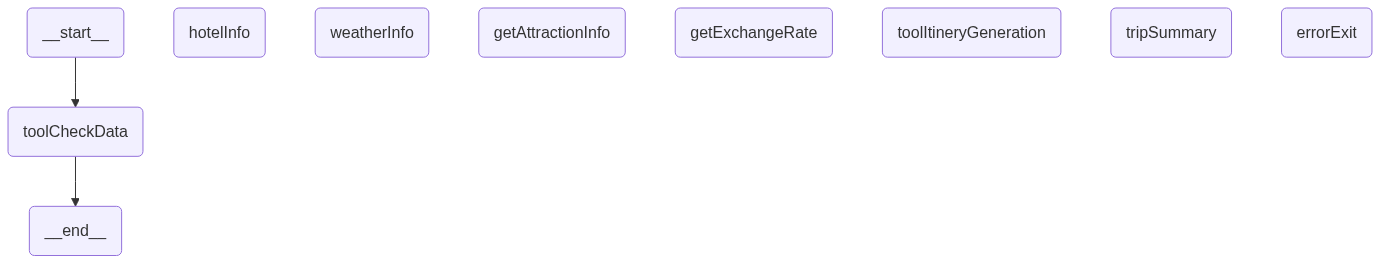

In [1565]:
from langgraph.graph import StateGraph

workflow = StateGraph(AgentState)

# Nodes
workflow.add_node("toolCheckData", fetch_info_node)
workflow.add_node("hotelInfo", get_hotel_data)
workflow.add_node("weatherInfo", get_weather_info1)
workflow.add_node("getAttractionInfo", get_attraction)
workflow.add_node("getExchangeRate", get_exchange_rate_with_tavily)
workflow.add_node("toolItineryGeneration", get_itinery_generation)
workflow.add_node("tripSummary", generate_trip_summary)
workflow.add_node("errorExit", error_node)

# Entry point
workflow.add_edge(START, "toolCheckData")
workflow.add_edge("getAttractionInfo", "getExchangeRate")
# Conditional edges with fallback to errorExit
workflow.add_conditional_edges("toolCheckData", lambda state: "errorExit" if state.error else "hotelInfo")
workflow.add_conditional_edges("hotelInfo", lambda state: "errorExit" if state.error else "weatherInfo")
workflow.add_conditional_edges("weatherInfo", lambda state: "errorExit" if state.error else "getAttractionInfo")
#workflow.add_conditional_edges("getAttractionInfo", lambda state: "errorExit" if state.error else "getExchangeRate")
workflow.add_conditional_edges("getExchangeRate", lambda state: "errorExit" if state.error else "toolItineryGeneration")
workflow.add_conditional_edges("toolItineryGeneration", lambda state: "errorExit" if state.error else "tripSummary")

# Finish point
workflow.set_finish_point("tripSummary")

# Compile the graph
react_graph = workflow.compile()
from IPython.display import Image, display
display(Image(react_graph.get_graph().draw_mermaid_png()))

In [1570]:

#userQuery={"messages": "i panning travel  from india to japan on 12 to 14  jun 2026"}
#userQuery="i paning to travel pondicherry from india to japan from  14 jun 2026"
input_state = AgentState(messages=["I'm traveling from India to singapore on 26 to 30 jun 25 "])
#dict={"messages":[userQuery]}
stateContent =react_graph.invoke(input_state)

fetch_info_node -> I'm traveling from India to singapore on 26 ton 30 jun 25 
fetch_info_node_response {'status': 'success', 'data': {'fetech_info': {'cityfrom': 'India', 'cityto': 'Singapore', 'days': 5, 'traveldate': '26-06-2025'}}}
fetch_info {'cityfrom': 'India', 'cityto': 'Singapore', 'days': 5, 'traveldate': '26-06-2025'}
messages=["I'm traveling from India to singapore on 26 ton 30 jun 25 "] fetch_info={'cityfrom': 'India', 'cityto': 'Singapore', 'days': 5, 'traveldate': '26-06-2025'} hotel_info=None weather_info=None attraction_info=None rate_info=None itinerary_info=None summary_info=None error=None
get_hotel_data retun0-> [{'hotel_name': '4-star hotels in Singapore', 'average_price': 'S$193'}, {'hotel_name': '5-star hotels in Singapore', 'average_price': 'S$338'}]
get_hotel_data retun1-> [{'hotel_name': '4-star hotels in Singapore', 'average_price': 'S$193'}, {'hotel_name': '5-star hotels in Singapore', 'average_price': 'S$338'}]
[{'hotel_name': '4-star hotels in Singapore', 

In [ ]:

print(stateContent['messages'])  

["I'm traveling from India to singapore on 30 jul 26 for 5 days    "]
